In [20]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt
import os

def detect_sweep_start(signal, threshold=0.01):
    """
    Detect the start of the sine sweep based on amplitude threshold.
    """
    for i, sample in enumerate(signal):
        if abs(sample) > threshold:
            return i
    return 0  # Return 0 if no start is detected

def align_signals(recorded_sweep, inverse_filter, threshold=0.01):
    """
    Align recorded sweep with inverse filter based on detected sweep start.
    """
    start_index = detect_sweep_start(recorded_sweep, threshold)
    recorded_sweep = recorded_sweep[start_index:]
    min_length = min(len(recorded_sweep), len(inverse_filter))
    return recorded_sweep[:min_length], inverse_filter[:min_length]

def compute_rir(recorded_sweep, inverse_filter, fs, keep_duration=None):
    """
    Compute Room Impulse Response using deconvolution.
    """
    rir = fftconvolve(recorded_sweep, inverse_filter, mode='full')
    peak_index = np.argmax(np.abs(rir))
    
    if keep_duration:
        end_index = peak_index + int(fs * keep_duration)
        rir = rir[peak_index:end_index]
    else:
        rir = rir[peak_index:]
    
    return rir / np.max(np.abs(rir))

def plot_signal(signal, fs, title, xlabel='Time (s)', ylabel='Amplitude'):
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(signal)) / fs, signal)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

def plot_rir_and_spectrum(rir, fs):
    plt.figure(figsize=(12, 10))
    
    # Time domain plot
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(rir)) / fs, rir)
    plt.title('Room Impulse Response')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # Frequency domain plot
    plt.subplot(2, 1, 2)
    freq_response = np.abs(np.fft.rfft(rir))
    freq_axis = np.fft.rfftfreq(len(rir), d=1/fs)
    plt.semilogx(freq_axis, 20 * np.log10(freq_response))
    plt.title('Frequency Response of RIR')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.xlim(20, fs/2)
    plt.ylim(-60, 0)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_octave_bands(rir, fs):
    from scipy.signal import butter, filtfilt

    def octave_filter(signal, fs, center_freq, order=6):
        low = center_freq / 2**0.5
        high = center_freq * 2**0.5
        nyquist = 0.5 * fs
        low = low / nyquist
        high = high / nyquist
        b, a = butter(order, [low, high], btype='band')
        return filtfilt(b, a, signal)

    center_freqs = [31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000]
    levels = []
    for cf in center_freqs:
        filtered = octave_filter(rir, fs, cf)
        level = 20 * np.log10(np.sqrt(np.mean(filtered**2)))
        levels.append(level)
    
    plt.figure(figsize=(10, 6))
    plt.semilogx(center_freqs, levels, 'o-')
    plt.title('Octave Band Levels')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Level (dB)')
    plt.grid(True)
    plt.show()

Sine sweep and inverse filter generated and saved as 16-bit WAV files.


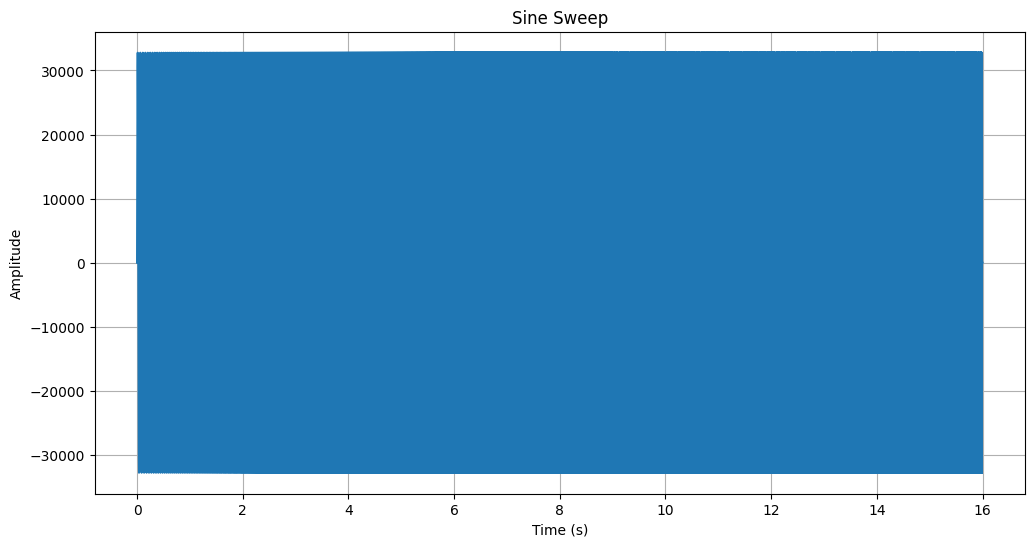

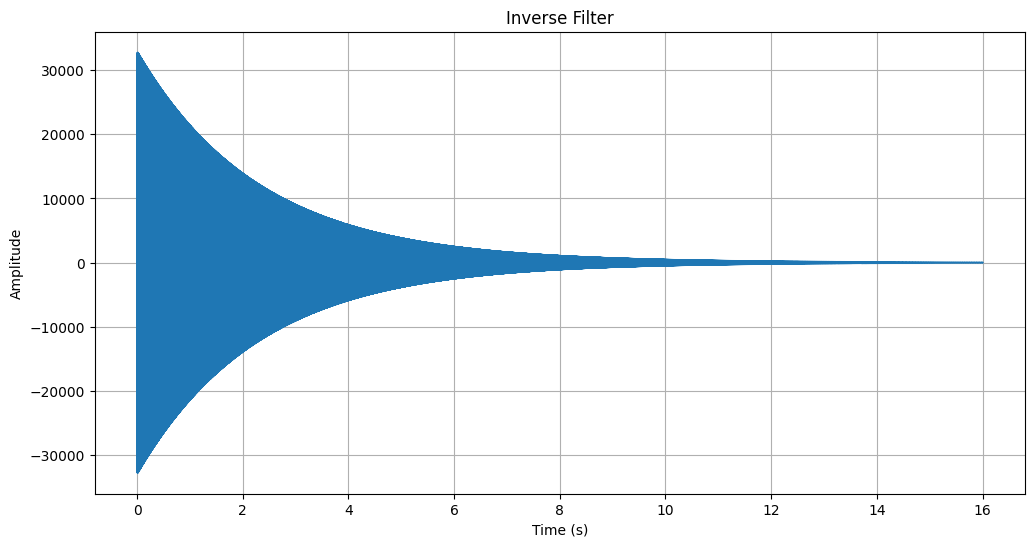

In [21]:
# Main execution
sweep, inverse_filter, fs = generate_exponential_sine_sweep()

# Save sweep and inverse filter
wavfile.write('sine_sweep_16bit_full.wav', fs, sweep)
wavfile.write('inverse_filter_16bit_full.wav', fs, inverse_filter)
relative_path = os.path.join('..', '..', 'Atiyeh-RIR-evaluation-Matlab', 'sounds', 'KT_GDP')
wavfile.write(os.path.join(relative_path, 'sine_sweep_16bit_full.wav'), fs, sweep)
wavfile.write(os.path.join(relative_path, 'inverse_filter_16bit_full.wav'), fs, inverse_filter)

plot_signal(sweep, fs, 'Sine Sweep')
plot_signal(inverse_filter, fs, 'Inverse Filter')


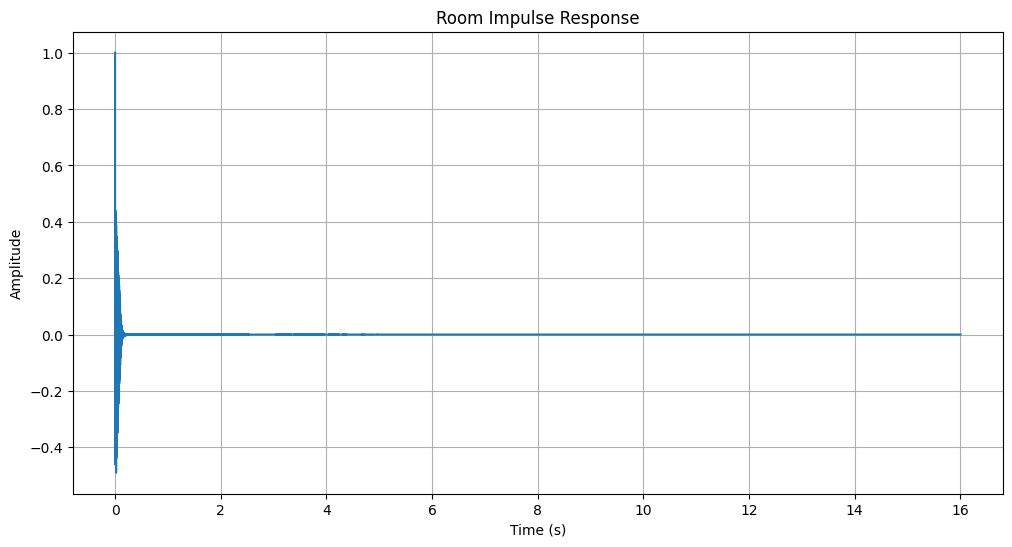

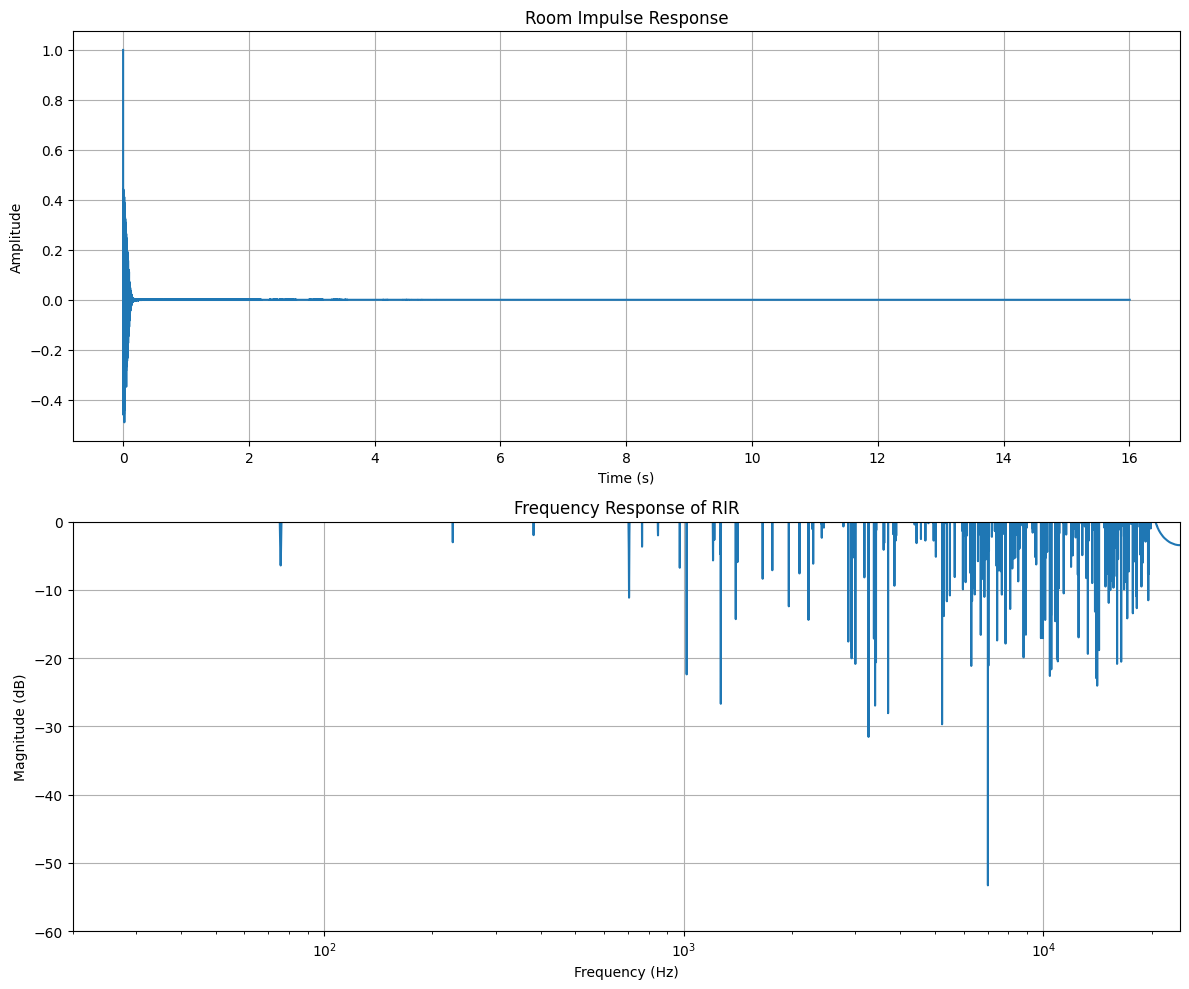

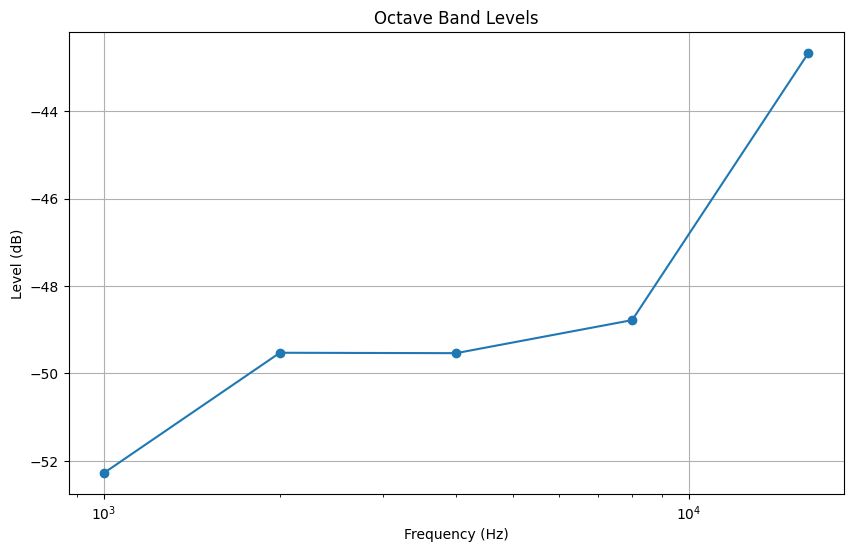

In [23]:
# Main execution
relative_path = os.path.join('..', '..', 'Atiyeh-RIR-evaluation-Matlab', 'sounds', 'KT_GDP')

# Load recorded sweep
fs_rec, recorded_sweep = wavfile.read('KT_Unity_bf.wav')
rec_ch1 = recorded_sweep[:, 1] if recorded_sweep.ndim > 1 else recorded_sweep
rec_ch1 = rec_ch1.astype(float) / 32768.0

# Load inverse filter
fs_inv, inverse_filter = wavfile.read('inverse_filter_16bit_full.wav')
inverse_filter = inverse_filter.astype(float) / 32768.0

# Align and compute RIR
rec_ch1, inverse_filter = align_signals(rec_ch1, inverse_filter)
rir = compute_rir(rec_ch1, inverse_filter, fs_rec)

# Save and plot RIR
output_path = os.path.join(relative_path, 'RIR_KT_Unity_bf.wav')
wavfile.write(output_path, fs_rec, np.int16(rir * 32767))
plot_signal(rir, fs_rec, 'Room Impulse Response')
plot_rir_and_spectrum(rir, fs_rec)
plot_octave_bands(rir, fs_rec)